In [1]:
import numpy as np
import pandas as pd

from dotenv import load_dotenv
import os

import unicodedata
import nltk
import spacy
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.metrics import precision_recall_curve, auc, precision_score, recall_score, f1_score, fbeta_score, roc_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import logging
import json
import re
import string 
import joblib
import warnings
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
import mlflow
import mlflow.sklearn
from sklearn.pipeline import Pipeline
from mlflow.models.signature import infer_signature

warnings.filterwarnings("ignore")

In [2]:
# Configuración del logging
logging.basicConfig(
    filename="errores_entrenamiento.log",
    level=logging.DEBUG,
    format="%(asctime)s - %(levelname)s - %(message)s"
)


In [3]:
# Load environment variables
try:
    load_dotenv()
    ruta_cst_twcs = os.getenv("customer_support_twitter_twcs")
    logging.info("Environment variables loaded successfully.")
except Exception as e:
    logging.error(f"Error loading environment variables: {e}")
    raise e

In [4]:
# load data
try:
    data_cst_twcs = pd.read_csv(ruta_cst_twcs)
    print(data_cst_twcs.shape)
    logging.info("Data loaded successfully.")
except FileNotFoundError as e:
    logging.error(f"File not found: {ruta_cst_twcs}")
    raise e

(2811774, 7)


In [5]:
# transform the 'inbound' column to int
try:
    data_cst_twcs['inbound'] = data_cst_twcs['inbound'].astype('int')
    logging.info("Data transformed successfully.")
except Exception as e:
    logging.error(f"Error transforming data: {e}")
    raise e

In [6]:
# load stopwords
try:
    nltk.download('punkt')
    #nltk.download('wordnet')
    nltk.download('stopwords')
    english_stopwords = stopwords.words('english')
except Exception as e:
    logging.error(f"Error loading stopwords: {e}")
    raise e

[nltk_data] Downloading package punkt to /home/alejo/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/alejo/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
# split the data into train, validation and test sets
# stratified split to maintain the same proportion of classes in each set
try:
    X_train, X_test, y_train, y_test = train_test_split(data_cst_twcs['text'], data_cst_twcs['inbound'], test_size=0.3, stratify=data_cst_twcs['inbound'])
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, stratify=y_train)
    print('X_train: ', X_train.shape)
    print('X_valid: ', X_valid.shape)
    print('X_test: ', X_test.shape)
    print('y_train: ', y_train.shape)
    print('y_valid: ', y_valid.shape)
    print('y_test: ', y_test.shape)
    logging.info("Data split into train, validation and test sets successfully.")
except Exception as e:
    logging.error(f"Error splitting data: {e}")
    raise e

X_train:  (1377768,)
X_valid:  (590473,)
X_test:  (843533,)
y_train:  (1377768,)
y_valid:  (590473,)
y_test:  (843533,)


In [8]:
# Set the experiment name
try:
    mlflow.create_experiment("experimento_catboost")
    print("Experimento creado")
    logging.info("Experiment created successfully.")
except:
    mlflow.set_experiment("experimento_catboost")
    print("Experimento ya existe")
    logging.info("Experiment already exists, set to existing experiment.")

Experimento ya existe


In [9]:
# Carga el modelo más reciente
try:
    model_name = "modelo_catboost_prueba"
    model_version = "latest"  # Indica que quieres la última versión disponible

    loaded_model = mlflow.sklearn.load_model(f"models:/{model_name}/{model_version}")
    logging.info(f"Model {model_name} version {model_version} loaded successfully.")
except Exception as e:
    logging.error(f"Error loading model: {e}")
    raise e

In [10]:
# evaluate predictions
try:
    y_pred = loaded_model.predict(X_test).astype(int)
    predictions = [round(value) for value in y_pred]
    logging.info("Predictions made successfully.")
except Exception as e:
    logging.error(f"Error making predictions: {e}")
    raise e

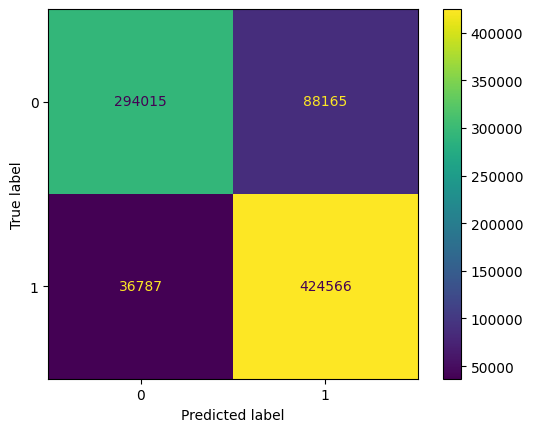

          Predicted 0  Predicted 1
Actual 0       294015        88165
Actual 1        36787       424566


In [11]:
try:
    cm = confusion_matrix(y_test, predictions)
    cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [0, 1])
    cm_display.plot()
    plt.show()

    # Crea un DataFrame a partir de la matriz de confusión
    cm_table = pd.DataFrame(cm, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

    # Muestra la matriz en forma de tabla
    print(cm_table)
    logging.info("Confusion matrix displayed successfully.")
except Exception as e:
    logging.error(f"Error displaying confusion matrix: {e}")
    raise e

In [12]:
# evaluate accuracy
try:
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    logging.info("Accuracy calculated successfully.")
except Exception as e:
    logging.error(f"Error calculating accuracy: {e}")
    raise e

Accuracy: 85.19%


In [13]:
# evaluate presicion
try:
    presicion = precision_score(y_test, predictions)
    print("Precision: %.2f%%" % (presicion * 100.0))
    logging.info("Precision calculated successfully.")
except Exception as e:
    logging.error(f"Error calculating precision: {e}")
    raise e

Precision: 82.80%


In [14]:
# evaluate recall
try:
    recall = recall_score(y_test, predictions)
    print("Recall: %.2f%%" % (recall * 100.0))
    logging.info("Recall calculated successfully.")
except Exception as e:
    logging.error(f"Error calculating recall: {e}")
    raise e

Recall: 92.03%


In [15]:
# evaluate predictions
try:
    f1 = f1_score(y_test, predictions)
    print("F1-Score: %.2f%%" % (f1 * 100.0))
    logging.info("F1-Score calculated successfully.")
except Exception as e:
    logging.error(f"Error calculating F1-Score: {e}")
    raise e

F1-Score: 87.17%


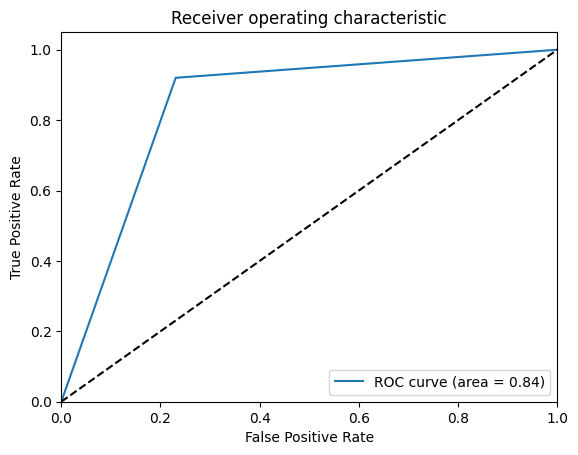

In [16]:
# evaluate predictions
try:
    fpr, tpr, thresholds = roc_curve(y_test, predictions) #precision_recall_curve
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    logging.info("ROC curve displayed successfully.")
except Exception as e:
    logging.error(f"Error displaying ROC curve: {e}")
    raise e

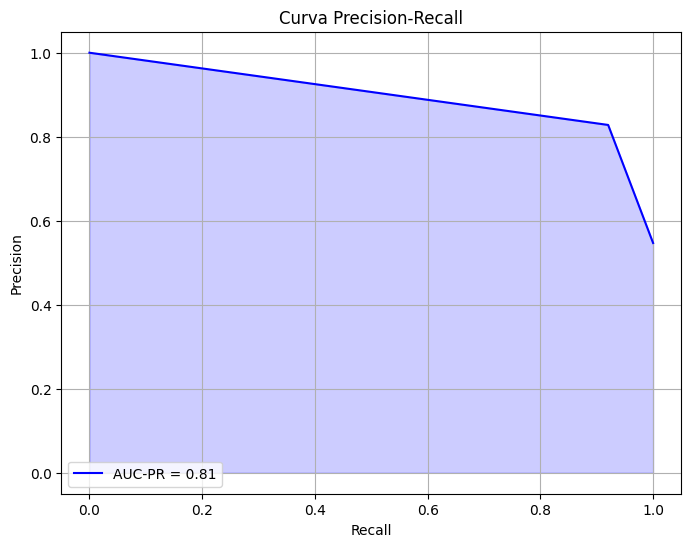

In [17]:
# evaluate predictions
try:
    precision, recall, thresholds = precision_recall_curve(y_test, predictions)

    auc_pr = average_precision_score(y_test, predictions)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, color='b', label=f'AUC-PR = {auc_pr:.2f}')
    plt.fill_between(recall, precision, alpha=0.2, color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Curva Precision-Recall')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.show()
    logging.info("Precision-Recall curve displayed successfully.")
except Exception as e:
    logging.error(f"Error displaying Precision-Recall curve: {e}")
    raise e